In [1]:
import sys
#add directory to path to allow importing of modules if not already in path
if "/home/d.gaillard/source/NIPTov-analysis-tools" not in sys.path:
    sys.path.append("/home/d.gaillard/source/NIPTov-analysis-tools")


import WCR_analysis_tools
from importlib import reload
reload(WCR_analysis_tools)
from WCR_analysis_tools import *

In [2]:
from pathlib import Path
base = Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/binwise_fragmentomics')


# get label data
label_df = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv')
label_df = label_df.set_index('PGDXID')
labels = label_df.loc[:, 'Lesion_Type']
data = {}

for file in base.glob('*b250000_*.csv'):
    # get label
    PGDXID = file.stem.split('_')[0]
    lab = labels.loc[PGDXID]
    data[PGDXID] = {'label': lab}

    # read file
    df = pd.read_csv(file, sep='\t')
    data[PGDXID]['df'] = df
    

In [3]:
import pandas as pd

processed_data = {} # same structure as data

for PGDXID in data.keys():
    lab = data[PGDXID]['label']
    processed_data[PGDXID] = {'label': lab}

    # create new df
    df = data[PGDXID]['df']
    df2 = pd.DataFrame()

    # copy some columns from df to df2
    df2['contig'] = df['contig']
    df2['start'] = df['start']
    df2['end'] = df['end']
    df2['mean_fragment_length'] = df['mean_fragment_length']
    df2['delta_score'] = df['delta_score']
    df2['total_reads'] = df['total_reads']

    # comvert columns to ratios
    df2['mate_unmapped_ratio'] = df['mate_unmapped_reads']/df['total_reads']
    df2['supplementary_ratio'] = df['supplementary_alignments']/df['total_reads']
    df2['extreme_read_length_ratio'] = df['extreme_fragment_lengths']/df['total_reads']
    df2['incorrect_orientation_ratio'] = df['incorrect_orientation_reads']/df['total_reads']


    ## merge df2 and df_cnv
    # determine path to cnv file based on label and PGDXID
    if lab.lower() == 'malignant':
        cnv_file = f'/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles/malignant/{PGDXID}_WGS_hg19_mrk_ref_benign_bins.bed'
    elif lab.lower() == 'benign':
        cnv_file = f'/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles/benign/{PGDXID}_WGS_hg19_mrk_looref_bins.bed'
    df_cnv = pd.read_csv(cnv_file, sep='\t')

    # merge df2 and df_cnv
    df2['cnv_ratio'] = df_cnv['ratio']
    df2['cnv_zscore'] = df_cnv['zscore']

    # remove chrY 
    df2 = df2[df2['contig'] != 'chrY']

    # add df2 to processed_data
    processed_data[PGDXID]['df'] = df2

data = processed_data

In [6]:
def align_yaxes(ax1, ax2):
    # get limits
    y_lims = [ax.get_ylim() for ax in [ax1, ax2]]

    # take extreme values for limits
    y_min = min([y[0] for y in y_lims])
    y_max = max([y[1] for y in y_lims])

    # set limits
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)

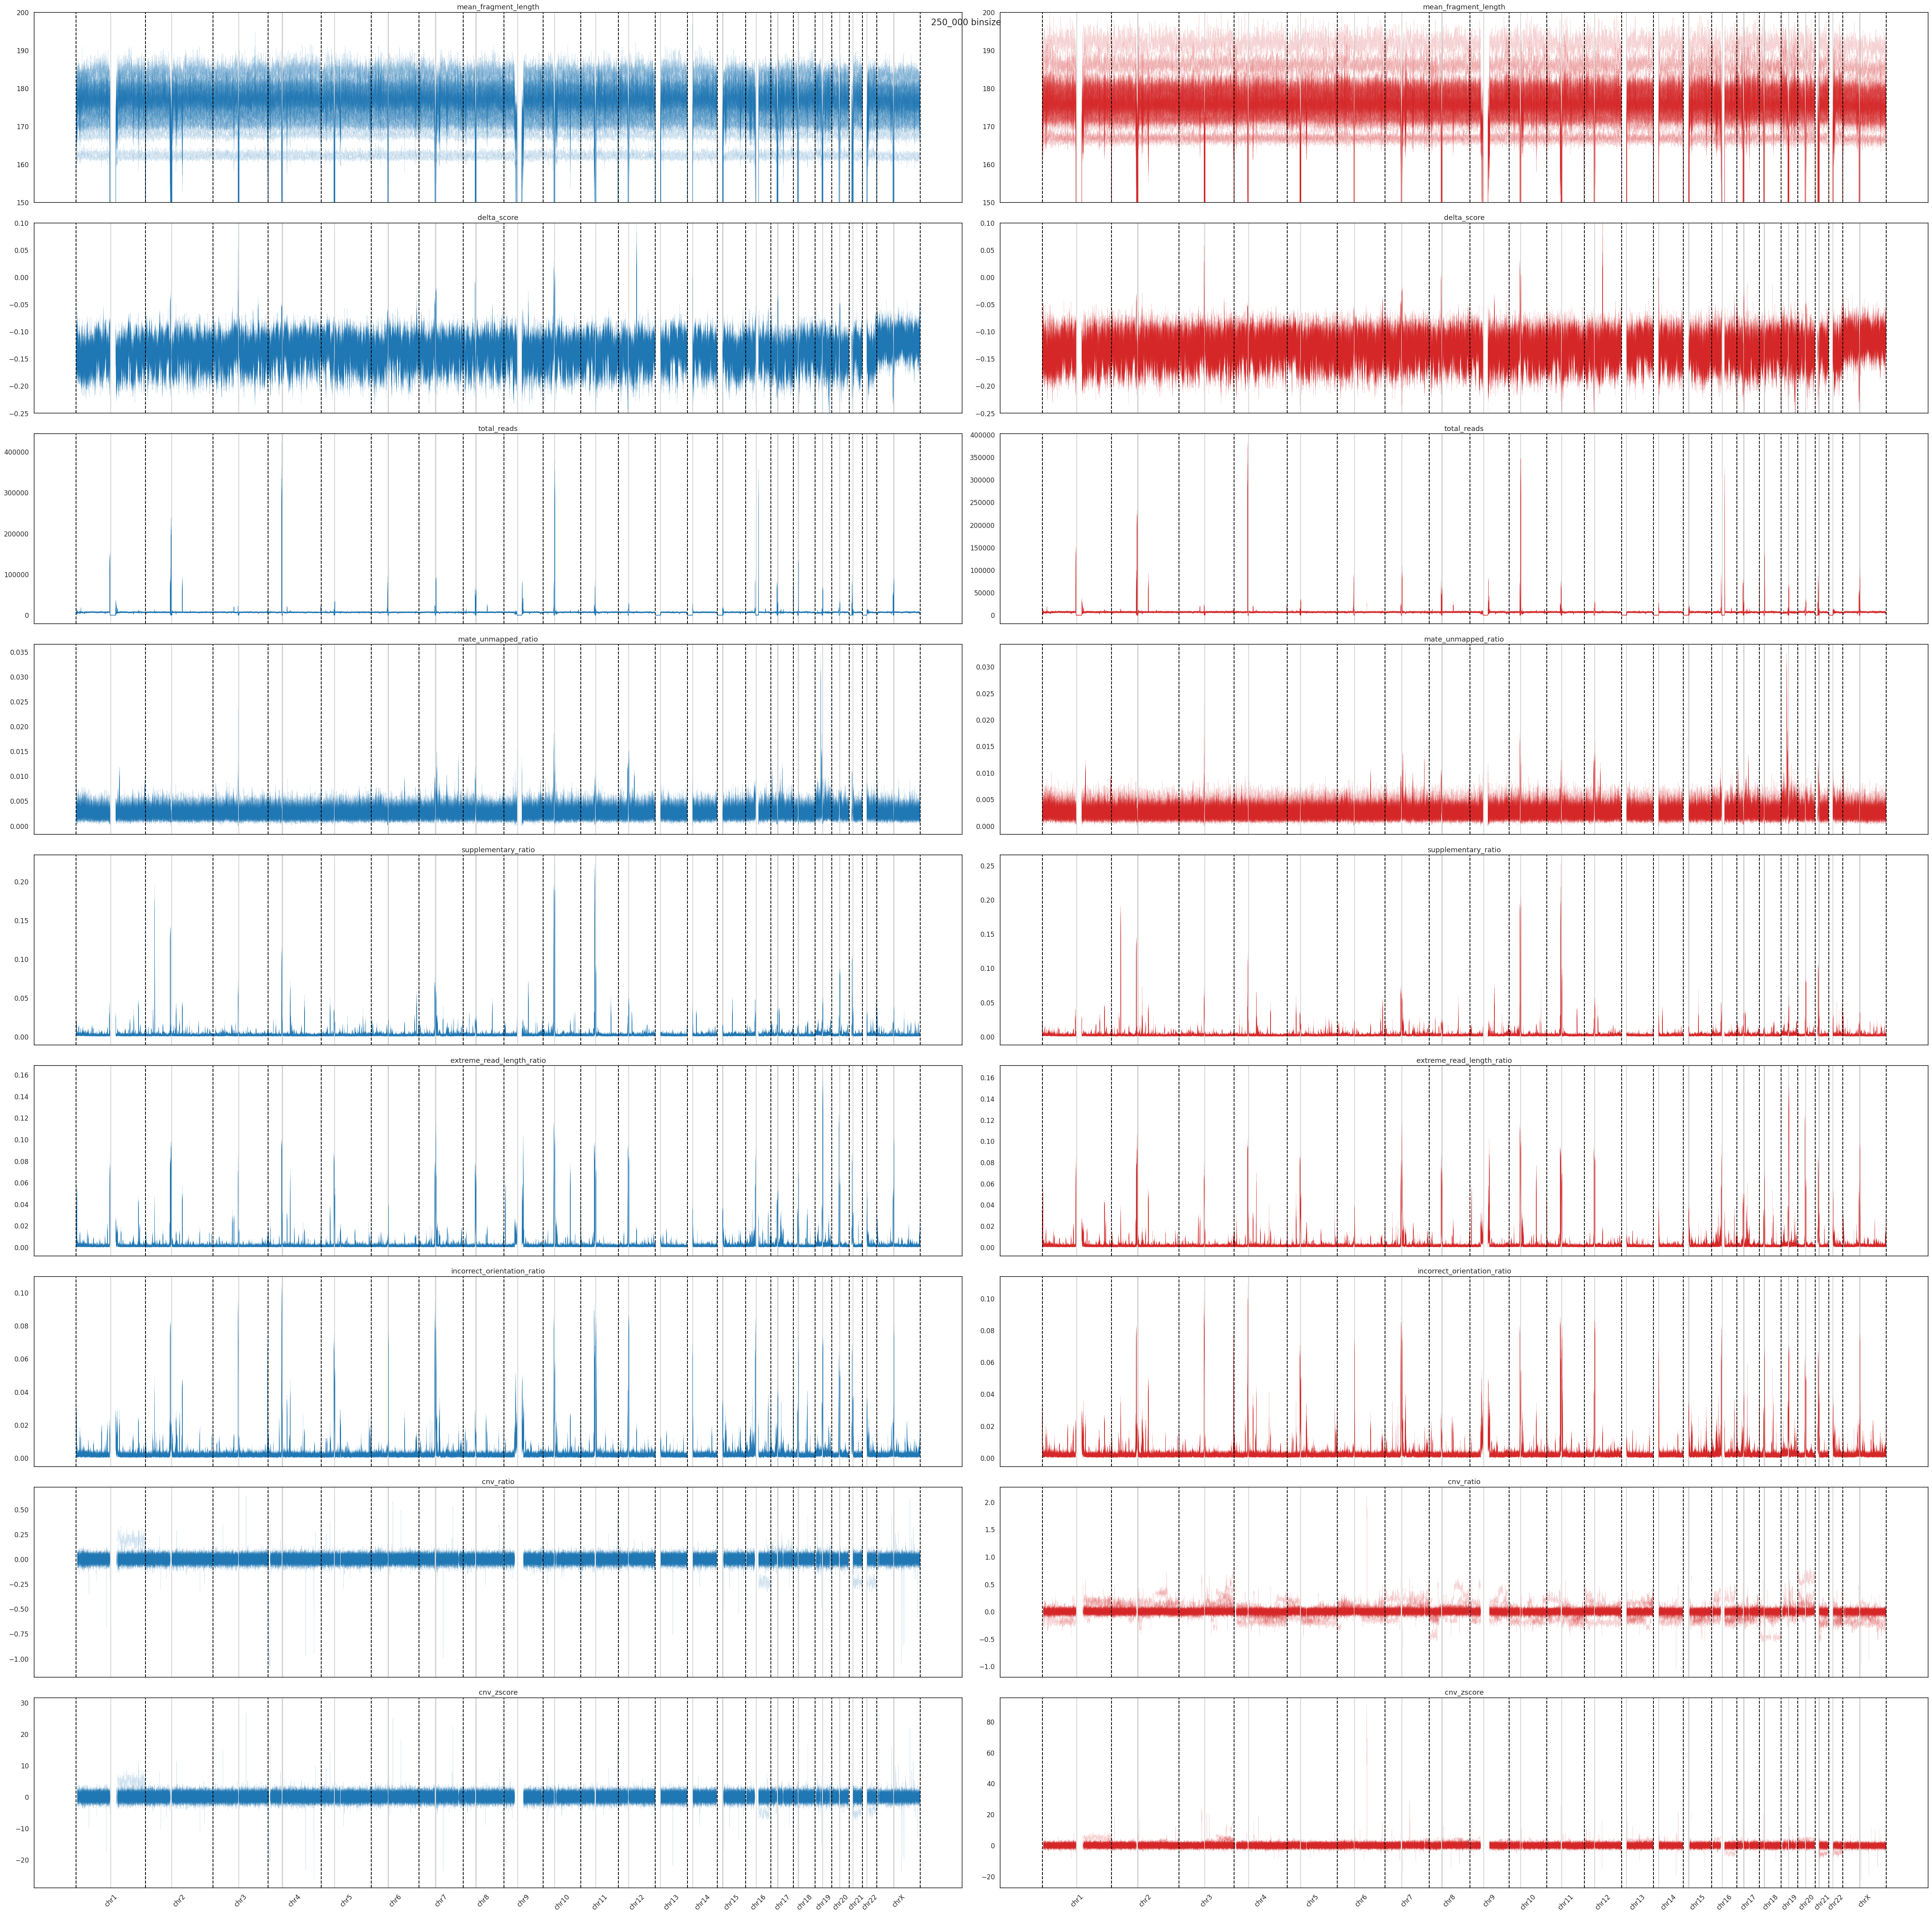

In [7]:

# code to plot all features 

# first deterime how many subplots we need under each other. 1 per feature
df1 = data[list(data.keys())[0]]['df']
features = df1.columns[3:].tolist()
fig, axs = plt.subplots(len(features), 2, figsize=(50, 50), sharex=True)

for i, feature in enumerate(features):
    for ax in axs[i, :]:
        ax.set_title(feature)
    for PGDXID in data.keys():
        df = data[PGDXID]['df']
        label = data[PGDXID]['label']
        if label == 'Malignant':
            is_malignant = 1
            color = 'tab:red'
        else:
            is_malignant = 0
            color = 'tab:blue'

        vector = df.loc[:, feature].values
        axs[i, is_malignant].plot(vector, alpha=0.2, color=color, linewidth=0.5)

#next for labeling the xaxis we need to know the number of bins for each chromosome.
# count the number of occurences of each chromosome in the sample_dfs[0]
chromosome_counts = df1.iloc[:, 0].value_counts().to_dict()
chromosome_ordered = df1.iloc[:, 0].unique().tolist()

# cumulatively sum the counts to get the end of each chromosome
chromosome_ends = np.cumsum([chromosome_counts[chromosome] for chromosome in chromosome_ordered])
chromosome_ends = np.insert(chromosome_ends, 0, 0)

# plot the chromosome ends as vertical lines over all the subplots
for chromosome_end in chromosome_ends:
    for ax in axs.ravel():
        ax.axvline(chromosome_end, color='black', linestyle='--')

# now we can plot the xaxis labels between the start and the end of each chromosome
# the start is the previous chromosome end, and the end is the current chromosome end using xtick labels
# set xticks to the middle of each chromosome
xticks = [(chromosome_ends[i] + chromosome_ends[i+1])/2 for i in range(len(chromosome_ends)-1)]
# set xtick labels to the chromosome names
xtick_labels = chromosome_ordered
# set xticks and xtick labels for each subplot
for ax in axs.ravel():
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45)

## load centromere data
centromere_df = pd.read_csv('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/data/hg19_centromere.bed', sep='\t', header=None)
# drop last column
centromere_df = centromere_df.iloc[:, :-1]
# rename columns
centromere_df.columns = ['chromosome', 'start', 'end']

# draw lightgrey rectangles over the centromere regions for each chromosome first determine which bin contains the centromere start and end. then draw a rectangle over the corresponding xaxis region
for i, chromosome in enumerate(chromosome_ordered):
    centromere_start = centromere_df[centromere_df['chromosome'] == chromosome]['start'].values[0]
    centromere_end = centromere_df[centromere_df['chromosome'] == chromosome]['end'].values[0]

    # determine which row contains the centromere start and end
    start_row = np.where(df1.iloc[:, 1].values > centromere_start)[0][0] + chromosome_ends[i]
    end_row = np.where(df1.iloc[:, 2].values > centromere_end)[0][0] + chromosome_ends[i]
    # translate the start and end rows with the start of each chromsome

    # draw rectangle over the corresponding xaxis region, for each subplot. start counting
    for ax in axs.ravel():
        ax.axvspan(start_row, end_row+2, facecolor='black', alpha=0.2)
        


# for axrow in axs:
#     align_yaxes(axrow[0], axrow[1])

for ax in axs[0,:]:
    ax.set_ylim(150, 200)
for ax in axs[1,:]:
    ax.set_ylim(-0.25, 0.1)

fig.suptitle('250_000 binsize', fontsize=16)
fig.tight_layout()
plt.show()

In [27]:
len(data)

98

In [62]:
len(cnv_ratio_matrix)

98

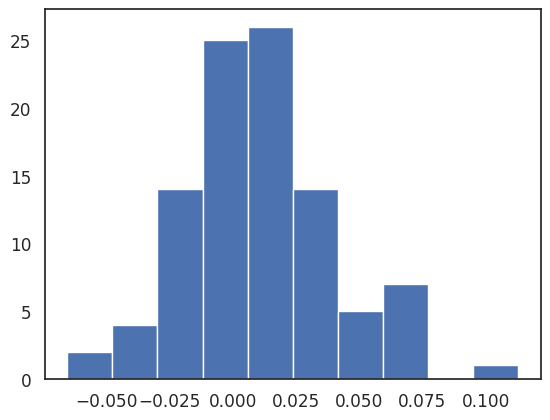

/home/d.gaillard/miniconda3/envs/wgs/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/d.gaillard/miniconda3/envs/wgs/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


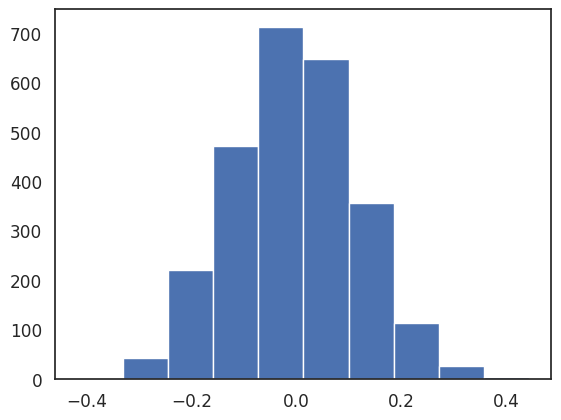

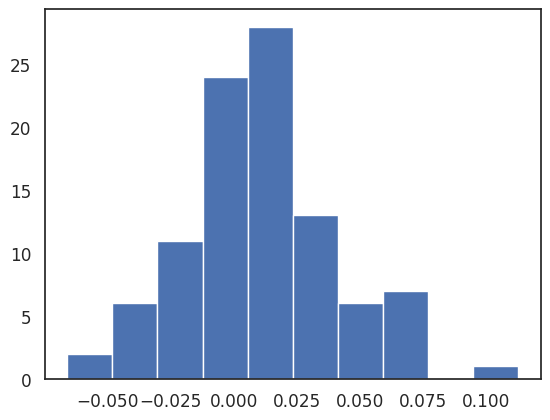

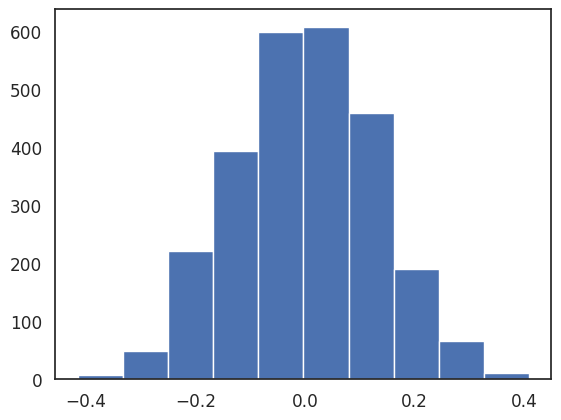

In [69]:
# next we calculate the correlation between the features and the cnv_ratio and cnv_zscore
# first we need to get the cnv_ratio and cnv_zscore for each bin
cnv_ratio_matrix = np.zeros((len(data), len(df1)))
cnv_zscore_matrix = np.zeros((len(data), len(df1)))
mean_fragment_length_matrix = np.zeros((len(data), len(df1)))
for i, PGDXID in enumerate(data.keys()):
    df = data[PGDXID]['df']
    cnv_ratio_matrix[i, :] = df['cnv_ratio'].values
    cnv_zscore_matrix[i, :] = df['cnv_zscore'].values
    mean_fragment_length_matrix[i, :] = df['mean_fragment_length'].values

# remove columns (bins) if any of the matrices contains a nan value. Do th
cnv_ratio_nans = np.isnan(cnv_ratio_matrix).any(axis=0)
cnv_zscore_nans = np.isnan(cnv_zscore_matrix).any(axis=0)
mean_fragment_length_matrix_nans = np.isnan(mean_fragment_length_matrix).any(axis=0)

# union of all the nans
nans = cnv_ratio_nans | cnv_zscore_nans | mean_fragment_length_matrix_nans

# remove the columns with nans
cnv_ratio_matrix = cnv_ratio_matrix[:, ~nans]
cnv_zscore_matrix = cnv_zscore_matrix[:, ~nans]
mean_fragment_length_matrix = mean_fragment_length_matrix[:, ~nans]

## cnv_ratio vs mean_fragment_length
# for each row (sample) calculate the correlation between the cnv_ratio and mean_fragment_length
cnv_ratio_mean_fragment_length_correlation = np.zeros(len(data))

for i in range(len(data)):
    cnv_ratio_mean_fragment_length_correlation[i] = np.corrcoef(cnv_ratio_matrix[i, :], mean_fragment_length_matrix[i, :])[0, 1]

# plot the correlation between the cnv_ratio and mean_fragment_length
plt.hist(cnv_ratio_mean_fragment_length_correlation)
plt.show()

# now for each column (bin) calculate the correlation between the cnv_ratio and mean_fragment_length
cnv_ratio_mean_fragment_length_correlation = np.zeros(cnv_ratio_matrix.shape[1])

for i in range(cnv_ratio_matrix.shape[1]):
    cnv_ratio_mean_fragment_length_correlation[i] = np.corrcoef(cnv_ratio_matrix[:, i], mean_fragment_length_matrix[:, i])[0, 1]

# plot the correlation between the cnv_ratio and mean_fragment_length
plt.hist(cnv_ratio_mean_fragment_length_correlation)
plt.show()

## cnv_zscore vs mean_fragment_length
# for each row (sample) calculate the correlation between the cnv_zscore and mean_fragment_length
cnv_zscore_mean_fragment_length_correlation = np.zeros(len(data))

for i in range(len(data)):
    cnv_zscore_mean_fragment_length_correlation[i] = np.corrcoef(cnv_zscore_matrix[i, :], mean_fragment_length_matrix[i, :])[0, 1]

# plot the correlation between the cnv_zscore and mean_fragment_length
plt.hist(cnv_zscore_mean_fragment_length_correlation)
plt.show()

# now for each column (bin) calculate the correlation between the cnv_zscore and mean_fragment_length
cnv_zscore_mean_fragment_length_correlation = np.zeros(cnv_zscore_matrix.shape[1])

for i in range(cnv_zscore_matrix.shape[1]):
    cnv_zscore_mean_fragment_length_correlation[i] = np.corrcoef(cnv_zscore_matrix[:, i], mean_fragment_length_matrix[:, i])[0, 1]

# plot the correlation between the cnv_zscore and mean_fragment_length
plt.hist(cnv_zscore_mean_fragment_length_correlation)
plt.show()

In [66]:
# we redo the code above but now we procedurally plot the correlation between the cnv_ratio and all other features



(2746,)